# Bike Sharing in Washington D.C.
## Rental bikes in 2011 and 2012 with corresponding weather and seasonal info

Data Source: https://www.kaggle.com/marklvl/bike-sharing-dataset

***Customer: Shuaib Yunus***  
***Data Scientist: Arndt Allhorn***

## The Goals

* accurate demand prediction
* interpretability

## The Journey

1. started with a ridge regression
1. tried a couple of other algorithms as well as time series forecasting
1. ended up with a tree-based ensemble

## The Results

* there's seasonality and trend in the data
* random forest outperformed the linear models
* data is noisy and has high variance => it's hard to make accurate predictions

# Prerequisites

Packages used in this notebook:

```
conda installl -y numpy pandas scikit-learn matplotlib seaborn plotly ipykernel
pip install pandas_profiling
pip install git+https://github.com/WillKoehrsen/feature-selector
```

# Setup

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# activate output for values of multiple statements at once:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# Load the Data

In [2]:
df = pd.read_csv(os.getcwd()+"/data/day.csv")
df["dteday"] = pd.to_datetime(df["dteday"])
df = df.sort_values(by="dteday",ascending=True)
print("shape: ",df.shape)
df.head()

shape:  (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Explorative Data Analysis

## Profile Report

*Reminder: show correlation matrix*

In [3]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,731
Total Missing (%),0.0%
Total size in memory,97.1 KiB
Average record size in memory,136.0 B
Numeric,10
Categorical,0
Boolean,3
Date,1
Text (Unique),0
Rejected,2


## Time Series Plot

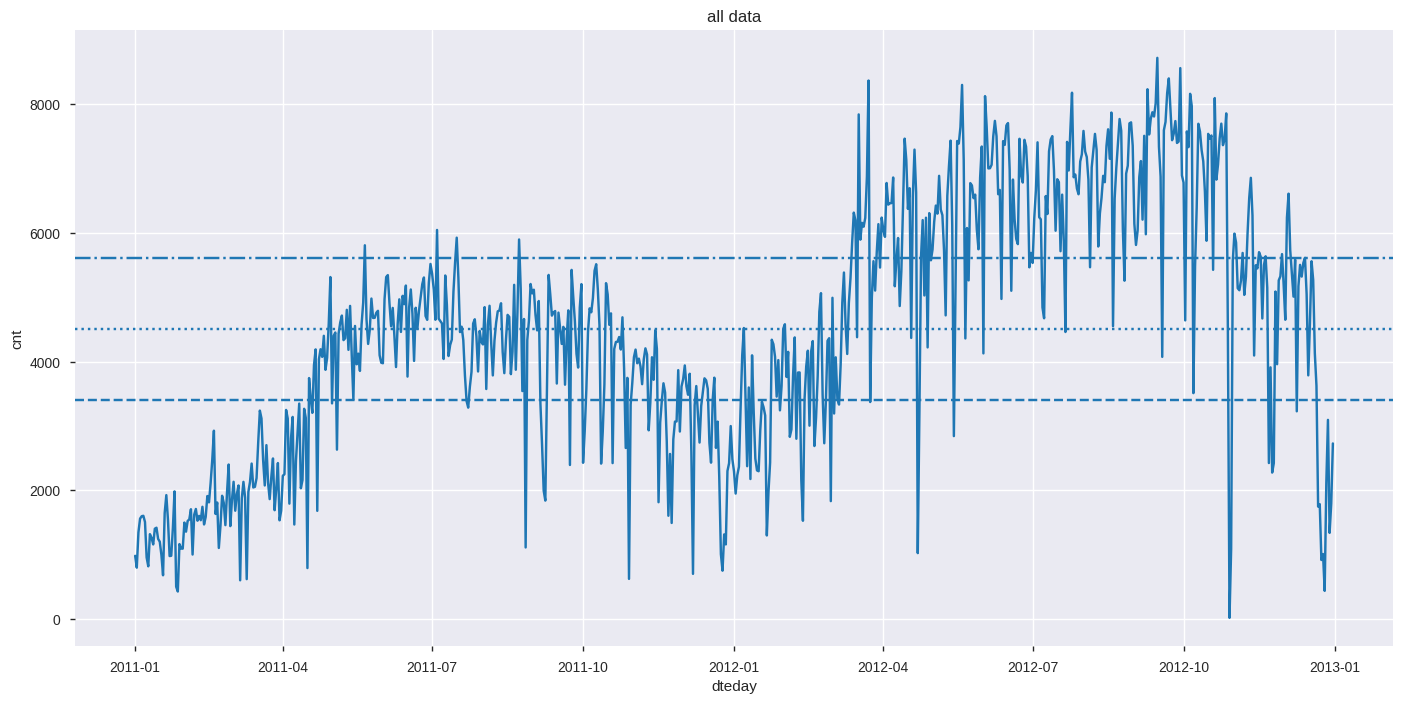

In [42]:
f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", data=df) # Plot the response over time
plt.title("all data")

plt.axhline(y=np.mean(df.cnt), linestyle=":") # add vertical line for overall mean
plt.axhline(y=np.mean(df[df["yr"]==0].cnt), linestyle="--") # add vertical line for mean of year 1
plt.axhline(y=np.mean(df[df["yr"]==1].cnt), linestyle="-.") # add vertical line for mean of year 2

plt.show(g)

# Feature Engineering

In [5]:
# add weekend column
df["weekend"] = 0
df.loc[df["weekday"].isin([5,6]), "weekend"] = 1
df["weekend"].value_counts()

0    522
1    209
Name: weekend, dtype: int64

# Feature Importance

* How useful/valuable was each feature in the construction of the trees within the model?
* Performance measure may be the purity (Gini index)
* According to a gradient boosting machine (GBM) learning model
    * Tree-based boosting ensemble
    * LightGBM library

* Source: https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0  
* Explanation: http://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/
* For more technical information on how feature importance is calculated in boosted decision trees, see Section 10.13.1 “Relative Importance of Predictor Variables” of the book The Elements of Statistical Learning: Data Mining, Inference, and Prediction, page 367.
* one-hot-encoding not necessary for LightGBM (see [Features](https://lightgbm.readthedocs.io/en/latest/Features.html))

In [6]:
y = df["cnt"]
# exclude columns dteday, atemp, casual, registered, cnt:
X = df.loc[:,['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'weekend']]

from feature_selector import FeatureSelector

# Features are in train and labels are in train_labels
fs = FeatureSelector(data = X, labels = y)

# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'mse', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	valid_0's l2: 335945	valid_0's l2: 335945
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[246]	valid_0's l2: 384406	valid_0's l2: 384406
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	valid_0's l2: 345519	valid_0's l2: 345519
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[345]	valid_0's l2: 367306	valid_0's l2: 367306
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[245]	valid_0's l2: 406477	valid_0's l2: 406477
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[138]	valid_0's l2: 281321	valid_0's l2: 281321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iterat

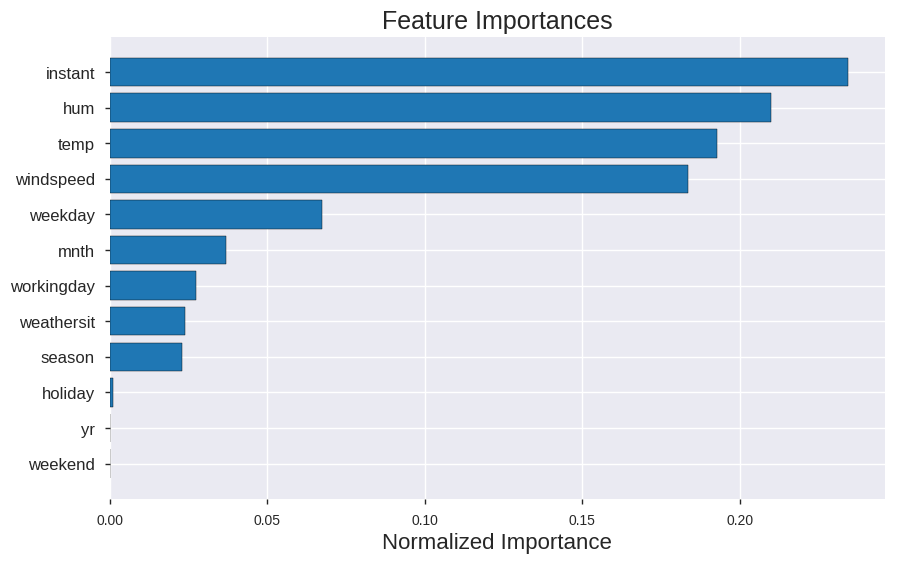

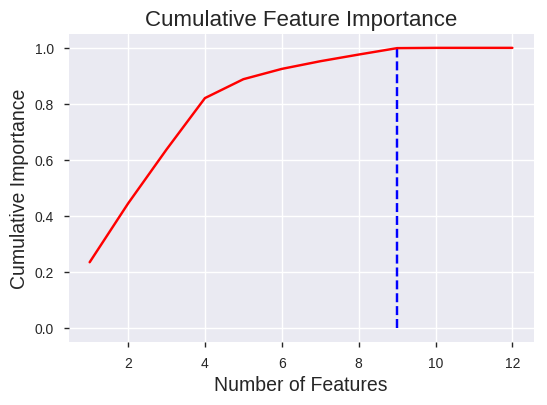

9 features required for 0.99 of cumulative importance


In [7]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

# Feature Selection and Dummy Encoding

In [8]:
# choose only importat predictors (see feature importance plot)
X = df.loc[:,['instant', 'weekday', 'workingday', 'temp', 'hum', 'windspeed']]

# add dummy-encoding of categorical variables
X = pd.concat([X,pd.get_dummies(df.mnth, prefix="mnth")],axis=1) # one-hot-encoded month
X = pd.concat([X,pd.get_dummies(df.weathersit, prefix="weathersit")],axis=1) # one-hot-encoded weathersit
X = pd.concat([X,pd.get_dummies(df.season, prefix="season")],axis=1) # one-hot-encoded season

X.dtypes

instant           int64
weekday           int64
workingday        int64
temp            float64
hum             float64
windspeed       float64
mnth_1            uint8
mnth_2            uint8
mnth_3            uint8
mnth_4            uint8
mnth_5            uint8
mnth_6            uint8
mnth_7            uint8
mnth_8            uint8
mnth_9            uint8
mnth_10           uint8
mnth_11           uint8
mnth_12           uint8
weathersit_1      uint8
weathersit_2      uint8
weathersit_3      uint8
season_1          uint8
season_2          uint8
season_3          uint8
season_4          uint8
dtype: object

# Train-Test-Split

In [46]:
RANDOM_SPLIT = False

if RANDOM_SPLIT:
    
    # TODO: random splitting causes data leakage!
    # use sklearn.model_selection.TimeSeriesSplit instead
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
else:

    # don't split random but take the first 18 month as train data and the last 6 month as test data
    test_idx = df[(df["yr"]==1) & (df["mnth"]>5)].index

    X_test=X.iloc[test_idx,]
    y_test=y.iloc[test_idx,]

    X_train=X.drop(test_idx)
    y_train=y.drop(test_idx)

print("train shape (X and y):", X_train.shape, y_train.shape)
print("test shape (X and y):", X_test.shape, y_test.shape)

train shape (X and y): (517, 25) (517,)
test shape (X and y): (214, 25) (214,)


# Standardize the data

* it is best to apply ridge regression after standardizing the predictors
* otherwise the regularization term would penalize the predictors unequally
* dummy variables don't have to be standardized, for practicability reasons (but they could)
* we're fine, as `temp`, `hum` and `windspeed` came already standardized with the data set

Sources:  
https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression  
https://www.quora.com/How-bad-is-it-to-standardize-dummy-variables

# Hyperparameter Optimization

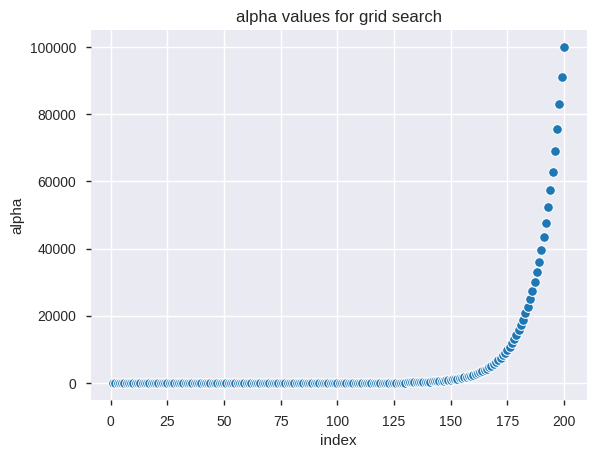

In [48]:
n_alphas = 200
alphas = np.logspace(-3, 5, n_alphas)

f, ax = plt.subplots()
g = sns.scatterplot(x=np.linspace(1,n_alphas,n_alphas), y=alphas)
ax.set_xlabel("index")
ax.set_ylabel("alpha")

plt.title("alpha values for grid search")
plt.show(g)

# Grid Search for Ridge Regression

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model

parameters = {
    'reg__alpha': (alphas).tolist()
}

pipe = Pipeline([
    ('reg', linear_model.Ridge())
])

# perform gridsearch to get the best regularizer
gs = GridSearchCV(estimator=pipe, param_grid=parameters, 
                  scoring="neg_mean_squared_error", cv=5, n_jobs=-1, iid=False)
gs.fit(X_train, y_train)
best_alpha = gs.best_params_["reg__alpha"]
print("Best alpha: ", best_alpha)

Best alpha:  0.2833096101839324


# Plot Ridge Coefficients as a Function of the Regularization

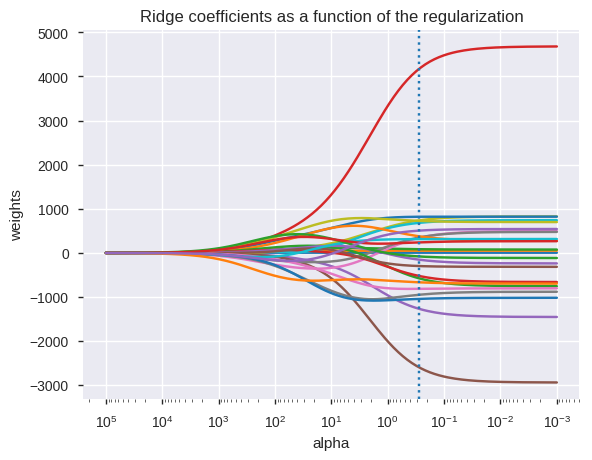

In [12]:
# #############################################################################
# Compute paths

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

plt.axvline(x=best_alpha, linestyle=":") # add vertical line for best alpha

plt.show()

Source: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

# Model Coefficients

In [26]:
reg = gs.best_estimator_.named_steps['reg']

print("intercept: ", reg.intercept_)
pd.DataFrame({"col" : X_train.columns, "coef" : reg.coef_})

intercept:  971.7897394447778


,col,coef
0,instant,5.412182
1,weekday,52.734252
2,workingday,84.950368
3,temp,4164.356726
4,hum,-1263.078415
5,windspeed,-2587.252765
6,mnth_1,338.111851
7,mnth_2,348.320511
8,mnth_3,735.910999
9,mnth_4,681.032556


# Model Evaluation

In [28]:
from sklearn.metrics import r2_score, mean_squared_error

print("R² (train) = {:.4}".format(r2_score(y_train, reg.predict(X_train))))

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE = {0:,.0f}".format(mse))
print("RMSE = {0:,.0f}".format(np.sqrt(mse)))

R² (train) = 0.842
MSE = 1,168,872
RMSE = 1,081


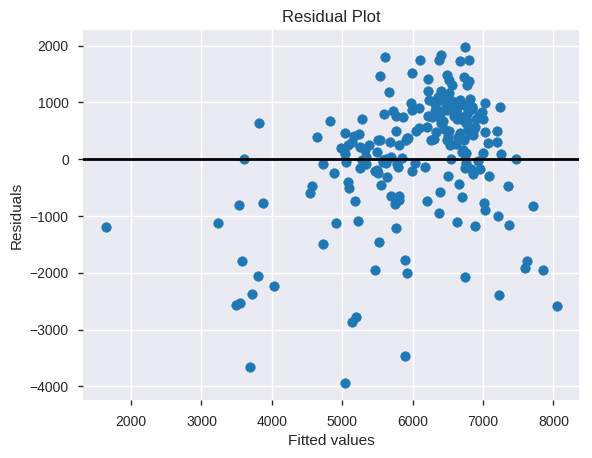

In [58]:
# Resiudal plot

residuals = y_test-y_pred

fig, ax = plt.subplots()
ax.scatter(y_pred, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title("Residual Plot")
plt.show()

# Plot Test vs. Pred

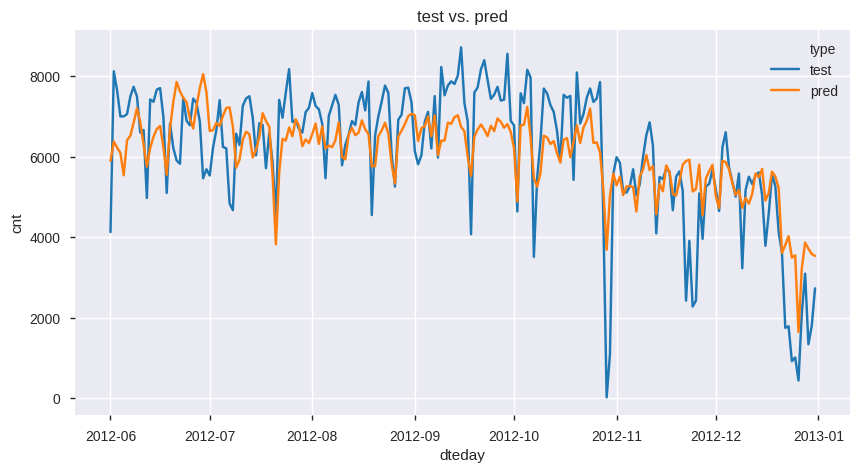

In [49]:
# prepare data for plotting (convert into long format)
test = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_test,
                         "type":"test"})
pred = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_pred,
                         "type":"pred"})
long_data=test.append(pred, ignore_index=True)

f, ax = plt.subplots(figsize=(10,5)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", hue="type", data=long_data) # Plot the response over time
plt.title("test vs. pred")
plt.show()

In [16]:
from plotly.offline import init_notebook_mode, iplot
import plotly.tools as tls
init_notebook_mode(connected=True)
plotly_fig = tls.mpl_to_plotly( f ) # ...produced some warnings...
iplot(plotly_fig)

In [17]:
import plotly.graph_objs as go
layout = go.Layout(
    autosize=False,
    width=600,
    height=600
)

# optional TODO: construct the whole diagram via plotly API (instead of converting from matplotlib/seaborn)
# see https://plot.ly/python/user-guide/

# Predicting the Future

* "Prediction is very difficult, especially about the future." - Niels Bohr, Nobel Prize Winner for Physics in 1922
* our model seems to underfit (high bias, low variance)
    * maybe a linear model is not flexible enough?

![alt text](images/future-meme.jpeg)

# Lessons Learned

* time data is special, samples are not independent
    * be carefull with random sampling / splitting, **it actually causes data leakage!**
    * solution: check out cross validation for time series
* for linear models
    * model time effects as dummies (like categorical variables)
    * and/or convert dates into discrete numbers (beginning at 0, otherwise the intercept is effected)
* no. of predictors: interpretability vs. model performance trade-off

# Further Links

**Time Series Cross Validation:**  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html  
https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

**More on Ridge Regression:**  
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/  
https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b  